In [1]:
'''
    @Author: King
    @Date: 2019.06.01
    @Purpose: DGL at a Glance
    @Introduction:   DGL is a Python package dedicated to deep learning on graphs, built atop existing tensor DL frameworks (e.g. Pytorch, MXNet) and simplifying the implementation of graph-based neural networks.
    @Datasets: 
    @Link : 
    @Reference : https://docs.dgl.ai/tutorials/basics/1_first.html
'''

'\n    @Author: King\n    @Date: 2019.06.01\n    @Purpose: DGL at a Glance\n    @Introduction:   DGL is a Python package dedicated to deep learning on graphs, built atop existing tensor DL frameworks (e.g. Pytorch, MXNet) and simplifying the implementation of graph-based neural networks.\n    @Datasets: \n    @Link : \n    @Reference : https://docs.dgl.ai/tutorials/basics/1_first.html\n'

# Step 0: Problem description

We start with the well-known “Zachary’s karate club” problem. The karate club is a social network which captures 34 members and document pairwise links between members who interact outside the club. The club later divides into two communities led by the instructor (node 0) and the club president (node 33). The network is visualized as follows with the color indicating the community:

![karate-clu](img/karate-club.png)

The task is to predict which side (0 or 33) each member tends to join given the social network itself.
该任务是用于预测每个成员趋向于加入给定社交网络中的哪一方（0 or 33）

# Step 1: Creating a graph in DGL

In [1]:
# Creating the graph for Zachary’s karate club goes as follows:
import dgl

def build_karate_club_graph():
    g = dgl.DGLGraph()
    # add 34 nodes into the graph; nodes are labeled from 0~33
    g.add_nodes(34)
    # all 78 edges as a list of tuples
    edge_list = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
        (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
        (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
        (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
        (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
        (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
        (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
        (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
        (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
        (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
        (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
        (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
        (33, 31), (33, 32)]
    # add edges two lists of nodes: src and dst
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bi-directional
    g.add_edges(dst, src)

    return g


# We can print out the number of nodes and edges in our newly constructed graph:
G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 34 nodes.
We have 156 edges.


In [2]:
import networkx as nx
import matplotlib.pyplot as plt     #导入绘图包matplotlib（需要安装，方法见第一篇笔记）        
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])


# Step 2: assign features to nodes or edges

Graph neural networks associate features with nodes and edges for training. For our classification example, we assign each node’s an input feature as a one-hot vector: node $v_i‘s$ feature vector is [0,…,1,…,0], where the $i_th$ position is one.

In DGL, we can add features for all nodes at once, using a feature tensor that batches node features along the first dimension. This code below adds the one-hot feature for all nodes:
我们可以一次为所有节点添加特性，使用沿第一个维度批处理节点特性的特性张量。

In [3]:
import torch
# 构建对角线上值为 1 的矩阵
G.ndata['feat'] = torch.eye(34)

In [4]:
# We can print out the node features to verify:
# print out node 2's input feature
print(G.nodes[2].data['feat'])

# print out node 10 and 11's input features
print(G.nodes[[10, 11]].data['feat'])

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


# Step 3: define a Graph Convolutional Network (GCN)

![](img/step3.png)

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# Define the message & reduce function
# NOTE: we ignore the GCN's normalization constant c_ij for this tutorial.
def gcn_message(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

In general, the nodes send information computed via the message functions, and aggregates incoming information with the reduce functions.

We then define a deeper GCN model that contains two GCN layers:

In [6]:
# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h
# The first layer transforms input features of size of 34 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(34, 5, 2)

# Step 4: data preparation and initialization

We use one-hot vectors to initialize the node features. Since this is a semi-supervised setting, only the instructor (node 0) and the club president (node 33) are assigned labels. The implementation is available as follow.

In [7]:
inputs = torch.eye(34)
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

# Step 5: train then visualize

The training loop is exactly the same as other PyTorch models. We (1) create an optimizer, (2) feed the inputs to the model, (3) calculate the loss and (4) use autograd to optimize the model.

In [8]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(30):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

D:\progrom\python\python\python3\lib\site-packages\dgl\base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


Epoch 0 | Loss: 0.6467
Epoch 1 | Loss: 0.5209
Epoch 2 | Loss: 0.4186
Epoch 3 | Loss: 0.3317
Epoch 4 | Loss: 0.2572
Epoch 5 | Loss: 0.1891
Epoch 6 | Loss: 0.1337
Epoch 7 | Loss: 0.0910
Epoch 8 | Loss: 0.0590
Epoch 9 | Loss: 0.0371
Epoch 10 | Loss: 0.0230
Epoch 11 | Loss: 0.0142
Epoch 12 | Loss: 0.0089
Epoch 13 | Loss: 0.0056
Epoch 14 | Loss: 0.0036
Epoch 15 | Loss: 0.0023
Epoch 16 | Loss: 0.0016
Epoch 17 | Loss: 0.0011
Epoch 18 | Loss: 0.0008
Epoch 19 | Loss: 0.0006
Epoch 20 | Loss: 0.0004
Epoch 21 | Loss: 0.0003
Epoch 22 | Loss: 0.0002
Epoch 23 | Loss: 0.0002
Epoch 24 | Loss: 0.0001
Epoch 25 | Loss: 0.0001
Epoch 26 | Loss: 0.0001
Epoch 27 | Loss: 0.0001
Epoch 28 | Loss: 0.0001
Epoch 29 | Loss: 0.0001


This is a rather toy example, so it does not even have a validation or test set. Instead, Since the model produces an output feature of size 2 for each node, we can visualize by plotting the output feature in a 2D space. The following code animates the training process from initial guess (where the nodes are not classified correctly at all) to the end (where the nodes are linearly separable).

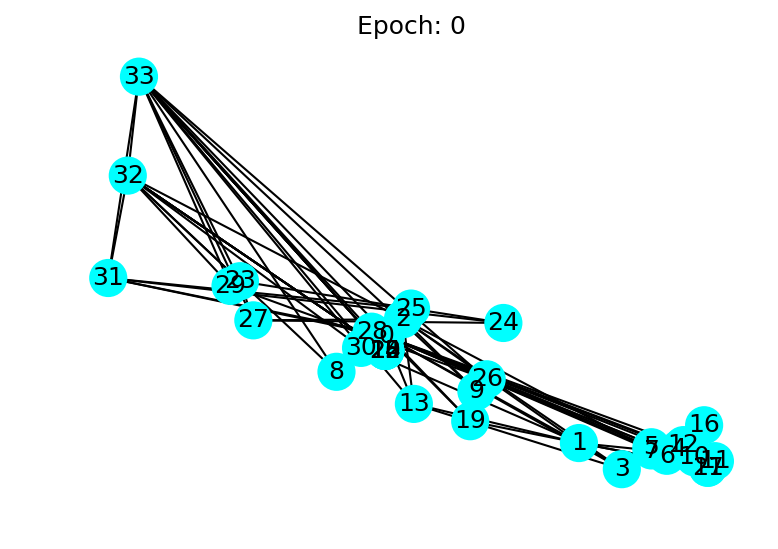

In [21]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
plt.show()

In [22]:
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)